In [1]:
import os
import sys
sys.path.insert(0, os.path.join(os.getenv("HOME"), "linked-data-latex"))

import logging
logging.basicConfig(level="INFO")

import pandas as pd
from matplotlib import pylab as plt
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
# oda:version "v0.1.6"

In [3]:
from odafunction.executors import default_execute_to_value
from odafunction.func.urifunc import URIipynbFunction, URIValue

focus_obs_name='total_3p'

# TODO: set version restriction here
# TODO: make nb2workflow store in remote storages
# TODO: make possible to disrupt equivalence with indications
# TODO: make common fd/fc depending on

v = default_execute_to_value(URIipynbFunction.from_generic_uri("file:///home/savchenk/grb221009/grbbase.ipynb")(focus_obs_name=focus_obs_name), valueclass=URIValue, cached=True)

import io
import tempfile
import base64
import tarfile
    
with tarfile.open(v['output_values']['fits_pack_url'].replace("file://", "")) as tar:
    tar.extractall(path=f"grbbase_fitspack_{focus_obs_name}")

!ls -ltor grbbase_fitspack*/*fits

INFO:odafunction.func.urifunc:constructing <class 'odafunction.func.urifunc.URIipynbFunction'> from uri=file:///home/savchenk/grb221009/grbbase.ipynb value=None provenance=None
INFO:odafunction.func.urifunc:parsing URI file:///home/savchenk/grb22100...(45)
INFO:odafunction.func.urifunc:parsed uri file:///home/savchenk/grb221009/grbbase.ipynb as {'modifier': None, 'schema': 'file', 'path': '/home/savchenk/grb221009/grbbase.ipynb', 'funcname': None, 'revision': None}
INFO:nb2workflow.nbadapter:notebook_dir: /home/savchenk/grb221009
INFO:nb2workflow.semantics:input combined turtle: @prefix oda: <http://odahub.io/ontology#> . <http://odahub.io/ontology#grbbase_72044160> a oda:version "v0.2.25" .
INFO:nb2workflow.semantics:this variation could not be parsed: @prefix oda: <http://odahub.io/ontology#> . <http://odahub.io/ontology#grbbase_72044160> a oda:version "v0.2.25" . due to at line 1 of <>:
Bad syntax (expected '.' or '}' or ']' at end of statement) at ^ in:
"...b' <http://odahub.io/ont

-rw-rw-r-- 1 savchenk  4472640 Feb 10 23:14 grbbase_fitspack_total_3p/isgri_total_3p_mosaic.fits
-rw-rw-r-- 1 savchenk  4472640 Feb 10 23:14 grbbase_fitspack_lc_total_3p/isgri_total_3p_mosaic.fits
-rw-rw-r-- 1 savchenk 17262720 Feb 10 23:14 grbbase_fitspack_total_3p/jemx1_total_3p_mosaic.fits
-rw-rw-r-- 1 savchenk 17262720 Feb 10 23:14 grbbase_fitspack_lc_total_3p/jemx1_total_3p_mosaic.fits
-rw-rw-r-- 1 savchenk 17262720 Feb 10 23:14 grbbase_fitspack_total_3p/jemx2_total_3p_mosaic.fits
-rw-rw-r-- 1 savchenk 17262720 Feb 10 23:14 grbbase_fitspack_lc_total_3p/jemx2_total_3p_mosaic.fits
-rw-rw-r-- 1 savchenk 17262720 Feb 10 23:18 grbbase_fitspack_total_3p/jemx1_mosaic.fits
-rw-rw-r-- 1 savchenk 17262720 Feb 10 23:18 grbbase_fitspack_lc_total_3p/jemx1_mosaic.fits
-rw-rw-r-- 1 savchenk 17262720 Feb 10 23:18 grbbase_fitspack_total_3p/jemx2_mosaic.fits
-rw-rw-r-- 1 savchenk 17262720 Feb 10 23:18 grbbase_fitspack_lc_total_3p/jemx2_mosaic.fits
-rw-rw-r-- 1 savchenk  4472640 Feb 10 23:18 grbbase

In [4]:
vacs = default_execute_to_value(URIipynbFunction.from_generic_uri("file:///home/savchenk/grb221009/acs.ipynb"), valueclass=URIValue, cached=True)
import pandas as pd
acslc = pd.read_csv(vacs['output_values']['acslc_csv_url'].replace("file://", ""))

INFO:odafunction.func.urifunc:constructing <class 'odafunction.func.urifunc.URIipynbFunction'> from uri=file:///home/savchenk/grb221009/acs.ipynb value=None provenance=None
INFO:odafunction.func.urifunc:parsing URI file:///home/savchenk/grb22100...(41)
INFO:odafunction.func.urifunc:parsed uri file:///home/savchenk/grb221009/acs.ipynb as {'modifier': None, 'schema': 'file', 'path': '/home/savchenk/grb221009/acs.ipynb', 'funcname': None, 'revision': None}
INFO:nb2workflow.nbadapter:notebook_dir: /home/savchenk/grb221009
INFO:nb2workflow.semantics:input combined turtle: @prefix oda: <http://odahub.io/ontology#> . <http://odahub.io/ontology#acs_72044160> a oda:version "v0.1.1"b .
INFO:nb2workflow.semantics:this variation could not be parsed: @prefix oda: <http://odahub.io/ontology#> . <http://odahub.io/ontology#acs_72044160> a oda:version "v0.1.1"b . due to at line 1 of <>:
Bad syntax (expected '.' or '}' or ']' at end of statement) at ^ in:
"...b'#> . <http://odahub.io/ontology#acs_720441

In [5]:
from astropy.time import Time

T0_isot = v['output_values']['data']['T0_isot']
T0_ijd = Time(T0_isot).mjd - 51544

In [6]:

from ddpaper.draftdata import load_globals

load_globals("eventinfo", globals())


INFO:ddpaper.draftdata:loading T0_ijd = 8317.553472222222
INFO:ddpaper.draftdata:loading T0_isot = '2022-10-09T13:17:00'
INFO:ddpaper.draftdata:loading source_name = 'GRB221009A'
INFO:ddpaper.draftdata:loading src_coord = <SkyCoord (ICRS): (ra, dec) in deg
    (288.26429167, 19.77308333)>


        59861.532764       -1.132263e-08
        59861.532875       -2.860962e-08
        59861.532967        8.372585e-09
        59861.533060        2.639475e-08
        59861.533152        5.800138e-08
        59861.533243        7.682774e-09
        59861.533336       -2.288027e-08
        59861.533427       -2.711575e-08
        59861.533519       -1.538258e-09
        59861.533612       -4.196331e-08


[]

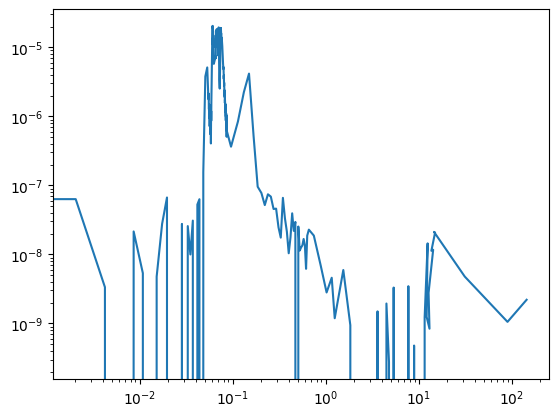

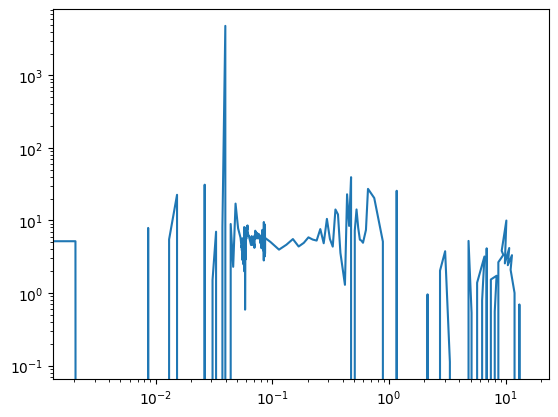

In [7]:
plt.figure()

!head picsit/grb221009a_afterglow_picsit_lc.txt

picsit_lc = pd.read_csv("picsit/grb221009a_afterglow_picsit_lc.txt", delim_whitespace=True, names=["mjd", "flux"])
picsit_hr = pd.read_csv("picsit/grb221009a_afterglow_picsit_hr.txt", delim_whitespace=True, names=["mjd", "hr"])

plt.plot(
    (picsit_lc.mjd - (T0_ijd + 51544))*24, 
    picsit_lc.flux, 
)

plt.loglog()

plt.figure()

plt.plot(
    (picsit_hr.mjd - (T0_ijd + 51544))*24, 
    picsit_hr.hr, 
)

plt.loglog()

In [8]:
import numpy as np
from rebin import rebin_in_bins



In [9]:
picsit_lc.sort_values('mjd', inplace=True)

picsit_lc['flux_err'] = picsit_lc.flux*0 + 1e-8
picsit_lc['dt']  = np.concatenate([[0], np.array(picsit_lc['mjd'])[1:] - np.array(picsit_lc['mjd'])[:-1]])

In [10]:
picsit_lc['dt'].min()b


0.0

In [ ]:
"""
obs1 (1-1.7 days, 8 rings):
 Model Flux 0.0014555 photons (1.0229e-11 ergs/cm^2/s) range (3.0000 - 10.000 keV)
 Model Flux 3.7829e-05 photons (7.6619e-13 ergs/cm^2/s) range (10.000 - 20.000 keV)
 Model Flux 3.359e-06 photons (1.455e-13 ergs/cm^2/s) range (20.000 - 100.00 keV)

obs2 (2-3.5 days, 4 rings):
 Model Flux 0.00027077 photons (1.8924e-12 ergs/cm^2/s) range (3.0000 - 10.000 keV)
 Model Flux 6.3803e-06 photons (1.2892e-13 ergs/cm^2/s) range (10.000 - 20.000 keV)
 Model Flux 5.4611e-07 photons (2.3622e-14 ergs/cm^2/s) range (20.000 - 100.00 keV)

obs3 (5.3-6.6 days, 2 rings):
 Model Flux 4.473e-05 photons (3.0338e-13 ergs/cm^2/s) range (3.0000 - 10.000 keV)
 Model Flux 7.8889e-07 photons (1.5892e-14 ergs/cm^2/s) range (10.000 - 20.000 keV)
 Model Flux 6.4597e-08 photons (2.7899e-15 ergs/cm^2/s) range (20.000 - 100.00 keV)
"""

In [11]:
import ogip.core
import ogip.tools

import importlib

importlib.reload(ogip.tools)


def get_conversion(instr):
    pha = ogip.core.open_something(f"grbbase_fitspack_{focus_obs_name}/{instr}_spectrum_GRB221009A_{focus_obs_name}.fits")
    rmf = ogip.core.open_something(f"grbbase_fitspack_{focus_obs_name}/{instr}_rmf_GRB221009A_{focus_obs_name}.fits")
    arf = ogip.core.open_something(f"grbbase_fitspack_{focus_obs_name}/{instr}_arf_GRB221009A_{focus_obs_name}.fits")


    model_generator = lambda p:(lambda x:(p[0]*(x/25.)))
    fit_result, fitted_model = ogip.tools.fit(model_generator, [7e-5], pha, rmf, None, 
                                            mask=~np.isnan(pha._rate))

    # TODO: check
    return ogip.tools.get_unfolding_factor(fitted_model, rmf, arf) * u.keV.to(u.erg)


get_conversion('IBIS').mean(), 1e-8/200

INFO:root:opened grbbase_fitspack_total_3p/IBIS_spectrum_GRB221009A_total_3p.fits as <ogip.spec.PHAI object at 0x7fc34d6527f0>
INFO:root:opened grbbase_fitspack_total_3p/IBIS_rmf_GRB221009A_total_3p.fits as <ogip.spec.RMF object at 0x7fc34d31dd00>
INFO:root:opened grbbase_fitspack_total_3p/IBIS_arf_GRB221009A_total_3p.fits as <ogip.spec.ARF object at 0x7fc34d2a57f0>


(2.824827e-11, 5e-11)

INFO:root:opened grbbase_fitspack_total_3p/JMX1_spectrum_GRB221009A_total_3p.fits as <ogip.spec.PHAI object at 0x7fc33c1df910>
INFO:root:opened grbbase_fitspack_total_3p/JMX1_rmf_GRB221009A_total_3p.fits as <ogip.spec.RMF object at 0x7fc33c116ee0>
INFO:root:opened grbbase_fitspack_total_3p/JMX1_arf_GRB221009A_total_3p.fits as <ogip.spec.ARF object at 0x7fc33c0ed100>
/tmp/ipykernel_3688700/4047075668.py:29: RuntimeWarning: invalid value encountered in double_scalars
  re = rebin_in_bins(d['TIME'] - T0_ijd, d['ERROR'], T, agg=lambda x:(np.sum(x**2))**0.5/len(x))
INFO:root:opened grbbase_fitspack_total_3p/JMX1_spectrum_GRB221009A_total_3p.fits as <ogip.spec.PHAI object at 0x7fc33c387190>
INFO:root:opened grbbase_fitspack_total_3p/JMX1_rmf_GRB221009A_total_3p.fits as <ogip.spec.RMF object at 0x7fc33c1468e0>
INFO:root:opened grbbase_fitspack_total_3p/JMX1_arf_GRB221009A_total_3p.fits as <ogip.spec.ARF object at 0x7fc33c163760>
INFO:root:opened grbbase_fitspack_total_3p/JMX1_spectrum_GRB2210

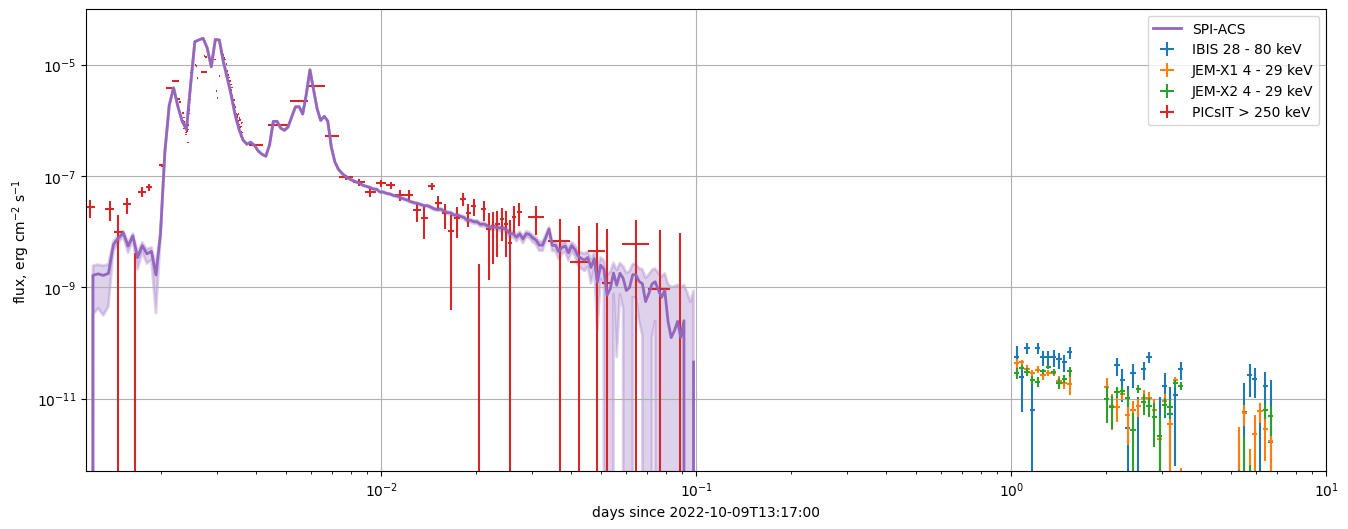

In [65]:
from astropy.io import fits


T = np.logspace(-1, 1, 120)
Tc = (T[1:] + T[:-1])/2.
dT = (T[1:] - T[:-1])/2.

plt.figure(figsize=(16, 6))

ijd2plot = lambda t:(t- T0_ijd)

plt.axhline(0, lw=2, c='k', alpha=0.5)


for label, n in [('IBIS', 'IBIS'),
                 ('JEM-X1', 'JMX1'),
                 ('JEM-X2', 'JMX2')
                ]:

    f = fits.open(f"grbbase_fitspack_total_3p/{n}_lc_GRB221009A.fits")
    d = f[1].data
    conversion_factor = get_conversion('JMX1').mean()

    # plt.errorbar(ijd2plot(isgri_lc['TIME']), isgri_lc['RATE'], isgri_lc['ERROR'])

    d['RATE'][d['ERROR'] > np.nanmedian(d['ERROR'])*10] = np.NaN    

    r = rebin_in_bins(d['TIME'] - T0_ijd, d['RATE'], T)
    re = rebin_in_bins(d['TIME'] - T0_ijd, d['ERROR'], T, agg=lambda x:(np.sum(x**2))**0.5/len(x))

    m = re < np.nanmedian(re)*3

    factor = 1e-8/200
    factor = conversion_factor

    plt.errorbar(
        Tc[m], 
        r[m]*factor,
        re[m]*factor,
        xerr=dT[m],
        label=f"{label} {int(f[1].header['E_MIN']):d} - {int(f[1].header['E_MAX']):d} keV",
        ls=""
    )

m = (picsit_lc.mjd - (T0_ijd + 51544)) < 0.1

plt.errorbar(
    (picsit_lc.mjd - (T0_ijd + 51544))[m], 
    picsit_lc.flux[m],
    picsit_lc.flux_err[m],
    xerr=picsit_lc.dt[m]/2,
    ls="",
    label='PICsIT > 250 keV'
)

n = 1000

def rebin(x, n):
    N = int(len(x)/n)
    return np.array(x[:N*n]).reshape((N, n)).sum(1)


## ACS
# TODO: check values
bkg = 5336.468053846153
cts_to_fluence = 3e-10
t_acs_offset = 70./24/3600

tail_change = 0.01
tail_bins = np.logspace(-3, -1, 200)

acs_T = np.concatenate([np.linspace(0, tail_change, int(tail_change/0.1)), tail_bins])
acs_Tc = (acs_T[1:] + acs_T[:-1])/2.
acs_dT = (acs_T[1:] - acs_T[:-1])/2.

from rebin import rebin_in_bins, rebin_bins_in_bins


acs_C = rebin_in_bins(acslc.t - T0_ijd, acslc.c - bkg - acslc.bkg_mean, acs_T, agg=lambda x:(np.sum(x))/len(x))
acs_Cmin = rebin_in_bins(acslc.t - T0_ijd, acslc.c - bkg - acslc.bkg_max, acs_T, agg=lambda x:(np.sum(x))/len(x))
acs_Cmax = rebin_in_bins(acslc.t - T0_ijd, acslc.c - bkg - acslc.bkg_min, acs_T, agg=lambda x:(np.sum(x))/len(x))

c = None

c = plt.plot(
    acs_Tc- t_acs_offset,
    acs_C * cts_to_fluence,
    lw=2,
    label="SPI-ACS"
)[0].get_color()


c = plt.fill_between(
    acs_Tc - t_acs_offset,
    acs_Cmin * cts_to_fluence,
    acs_Cmax * cts_to_fluence,
    lw=2,
    color=c,
    alpha=0.3
)


# c = plt.plot(
#     (rebin(acslc.t, n)/n - T0_ijd) - t_acs_offset,
#     rebin(acslc.c - acslc.bkg_mean - bkg, n)/n * cts_to_fluence,
#     lw=2
# )[0].get_color()

# plt.fill_between(
#     (rebin(acslc.t, n)/n - T0_ijd) - t_acs_offset,
#     rebin(acslc.c - acslc.bkg_max - bkg, n)/n * cts_to_fluence,
#     rebin(acslc.c - acslc.bkg_min - bkg, n)/n * cts_to_fluence,
#     color=c
# )

# TODO: picsit erange

plt.xlim([100./24/3600, 10])
plt.ylim([0.5e-12, 1e-4])

# plt.grid(which='both')
plt.grid()

plt.legend()

plt.xlabel(f"days since {T0_isot}")
plt.ylabel("flux, erg cm$^{-2}$ s$^{-1}$")

# plt.semilogx()
plt.loglog()

plt.savefig("lc.png")
plt.savefig("lc.pdf")

# TODO: plot early AG SPI-ACS
# TODO: plot model fitb
# TODO: plot rings contribution approx



In [62]:
f[1].header['E_MIN']

29.66

In [55]:
(acs_T[1:] - acs_T[:-1])*24*3600

array([4.09284558e+00, 4.28672735e+00, 4.48979348e+00, 4.70247903e+00,
       4.92523968e+00, 5.15855271e+00, 5.40291798e+00, 5.65885906e+00,
       5.92692429e+00, 6.20768802e+00, 6.50175177e+00, 6.80974559e+00,
       7.13232936e+00, 7.47019420e+00, 7.82406401e+00, 8.19469695e+00,
       8.58288710e+00, 8.98946617e+00, 9.41530526e+00, 9.86131672e+00,
       1.03284561e+01, 1.08177244e+01, 1.13301697e+01, 1.18668900e+01,
       1.24290353e+01, 1.30178098e+01, 1.36344752e+01, 1.42803525e+01,
       1.49568256e+01, 1.56653439e+01, 1.64074253e+01, 1.71846597e+01,
       1.79987125e+01, 1.88513277e+01, 1.97443320e+01, 2.06796387e+01,
       2.16592518e+01, 2.26852700e+01, 2.37598916e+01, 2.48854190e+01,
       2.60642637e+01, 2.72989512e+01, 2.85921271e+01, 2.99465618e+01,
       3.13651573e+01, 3.28509530e+01, 3.44071321e+01, 3.60370289e+01,
       3.77441353e+01, 3.95321089e+01, 4.14047804e+01, 4.33661620e+01,
       4.54204560e+01, 4.75720638e+01, 4.98255952e+01, 5.21858784e+01,
      

In [13]:
lc_pdf="lc.pdf"
comment_reconstruction="assuming slope of -2"